# Appendix D: Coarse-grained model


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit,minimize_scalar
import time
from pathlib import Path
figures_path = Path().resolve().parent / 'figures'

In [2]:


def generate_OU_noise_batch(n_realizations: int, n_sources: int, total_steps: int, 
                            dt_sim: float, tau_c_values: np.ndarray,
                            amplitude_values: np.ndarray) -> np.ndarray:
    """
    Generates OU noise for multiple realizations at once - FULLY VECTORIZED.
    
    Returns:
        noise: shape (n_realizations, n_sources, total_steps)
    """
    mu = 0.0
    
    # Pre-compute constants for all sources
    theta = 1.0 / tau_c_values  # shape (n_sources,)
    sigma = amplitude_values * np.sqrt(2 * theta)  # shape (n_sources,)
    
    exp_minus_theta_dt = np.exp(-theta * dt_sim)  # shape (n_sources,)
    term1_drift = mu * (1 - exp_minus_theta_dt)  # shape (n_sources,)
    variance = (sigma**2 * (1 - np.exp(-2 * theta * dt_sim))) / (2 * theta)
    term2_stochastic_std_dev = np.sqrt(variance)  # shape (n_sources,)
    
    # Initialize all paths at once: (n_realizations, n_sources)
    x = np.random.randn(n_realizations, n_sources) * amplitude_values[np.newaxis, :]
    
    # Allocate output: (n_realizations, n_sources, total_steps)
    noise = np.zeros((n_realizations, n_sources, total_steps))
    
    # Vectorized evolution over time
    for t in range(total_steps):
        # Generate random increments for all realizations and sources at once
        dW = np.random.randn(n_realizations, n_sources) * term2_stochastic_std_dev[np.newaxis, :]
        
        # Update: vectorized over realizations and sources
        x = x * exp_minus_theta_dt[np.newaxis, :] + term1_drift[np.newaxis, :] + dW
        
        # Store
        noise[:, :, t] = x
    
    return noise


In [3]:


def run_continuous_phase_evolution_vectorized(noise_batch: np.ndarray,
                                              x_trajectory: np.ndarray,
                                              x_sources: np.ndarray,
                                              xc: float,
                                              dt_sim: float,
                                              steps_per_period: int) -> tuple:
    """
    Vectorized phase evolution for continuous shuttling over ALL realizations.
    
    Args:
        noise_batch: shape (n_realizations, n_sources, total_steps)
        x_trajectory: shape (steps_per_period,) - position at each step
        x_sources: shape (n_sources,)
        xc: correlation length
        dt_sim: time step
        steps_per_period: steps in one period
    
    Returns:
        times: array of times (one per period)
        W_values: shape (n_realizations, n_periods) - return probability for each realization
    """
    n_realizations, n_sources, total_steps = noise_batch.shape
    n_periods = total_steps // steps_per_period
    
    # Pre-compute coupling matrix: shape (steps_per_period, n_sources)
    # For each position in trajectory, compute coupling to each source
    coupling_matrix = np.exp(-np.abs(x_trajectory[:, np.newaxis] - x_sources[np.newaxis, :]) / xc)
    
    # Reshape noise to (n_realizations, n_sources, n_periods, steps_per_period)
    noise_reshaped = noise_batch[:, :, :n_periods * steps_per_period].reshape(
        n_realizations, n_sources, n_periods, steps_per_period)
    
    # Compute total noise at qubit position for each realization and time step
    # coupling_matrix: (steps_per_period, n_sources) -> 'ab'
    # noise_reshaped: (n_realizations, n_sources, n_periods, steps_per_period) -> 'rbra'
    # Contract b (sources), keep r, x, a where x=n_periods
    xi_total = np.einsum('ab,rbxa->rxa', coupling_matrix, noise_reshaped)
    
    # Accumulate phase within each period
    # phi[r, p, t] = cumulative sum over t within period p for realization r
    phi_increments = xi_total * dt_sim
    phi_within_periods = np.cumsum(phi_increments, axis=2)
    
    # Get phase at end of each period
    phi_at_period_end = phi_within_periods[:, :, -1]  # shape (n_realizations, n_periods)
    
    # Accumulate across periods
    phi_cumulative = np.cumsum(phi_at_period_end, axis=1)  # shape (n_realizations, n_periods)
    
    # Compute return probability
    W_values = np.cos(phi_cumulative)
    
    # Time array
    times = np.arange(1, n_periods + 1) * steps_per_period * dt_sim
    
    return times, W_values


def run_bucket_phase_evolution_vectorized(noise_batch: np.ndarray,
                                         bucket_path: list,
                                         v_ni_matrix: np.ndarray,
                                         dt_bucket: float,
                                         dt_bucket_steps: int,
                                         max_repetitions: int) -> np.ndarray:
    """
    Vectorized phase evolution for bucket model over ALL realizations.
    
    Args:
        noise_batch: shape (n_realizations, n_sources, total_steps)
        bucket_path: list of bucket indices per step
        v_ni_matrix: shape (n_sources, n_buckets) - coupling matrix
        dt_bucket: time spent in each bucket
        dt_bucket_steps: number of simulation steps per bucket step
        max_repetitions: number of full periods
    
    Returns:
        W_values: shape (n_realizations, max_repetitions)
    """
    n_realizations, n_sources, total_steps = noise_batch.shape
    path_length = len(bucket_path)
    
    # Extract coupling for each bucket in the path: shape (n_sources, path_length)
    coupling_path = v_ni_matrix[:, bucket_path]  # (n_sources, path_length)
    
    # Subsample noise at bucket step times
    # We need to sample every dt_bucket_steps
    step_indices = np.arange(0, max_repetitions * path_length) * dt_bucket_steps
    step_indices = step_indices[step_indices < total_steps]
    noise_at_steps = noise_batch[:, :, step_indices]  # (n_realizations, n_sources, max_repetitions*path_length)
    
    # Reshape to periods: (n_realizations, n_sources, max_repetitions, path_length)
    noise_reshaped = noise_at_steps[:, :, :max_repetitions * path_length].reshape(
        n_realizations, n_sources, max_repetitions, path_length)
    
    # Apply couplings and sum over sources: (n_realizations, max_repetitions, path_length)
    # coupling_path: (n_sources, path_length) -> 'ab'
    # noise_reshaped: (n_realizations, n_sources, max_repetitions, path_length) -> 'raxb'
    # Contract a (sources), keep r, x, b
    xi_total = np.einsum('ab,raxb->rxb', coupling_path, noise_reshaped)
    
    # Accumulate phase within each period
    phi_increments = xi_total * dt_bucket
    phi_within_periods = np.sum(phi_increments, axis=2)  # shape (n_realizations, max_repetitions)
    
    # Accumulate across periods
    phi_cumulative = np.cumsum(phi_within_periods, axis=1)  # shape (n_realizations, max_repetitions)
    
    # Compute return probability
    W_values = np.cos(phi_cumulative)
    
    return W_values


def run_stationary_bucket_evolution_vectorized(noise_batch: np.ndarray,
                                              bucket_idx: int,
                                              v_ni_matrix: np.ndarray,
                                              dt_sim: float,
                                              steps_per_period: int,
                                              n_periods: int) -> tuple:
    """
    Vectorized stationary evolution at fixed bucket over ALL realizations.
    
    Args:
        noise_batch: shape (n_realizations, n_sources, total_steps)
        bucket_idx: which bucket to stay at
        v_ni_matrix: shape (n_sources, n_buckets)
        dt_sim: time step
        steps_per_period: steps per measurement period
        n_periods: number of periods
    
    Returns:
        times: array of times
        W_values: shape (n_realizations, n_periods)
    """
    n_realizations, n_sources, total_steps = noise_batch.shape
    
    # Get coupling for this bucket: shape (n_sources,)
    coupling = v_ni_matrix[:, bucket_idx]
    
    # Limit to available steps
    max_steps = n_periods * steps_per_period
    noise_truncated = noise_batch[:, :, :max_steps]  # (n_realizations, n_sources, max_steps)
    
    # Reshape to periods: (n_realizations, n_sources, n_periods, steps_per_period)
    noise_reshaped = noise_truncated.reshape(n_realizations, n_sources, n_periods, steps_per_period)
    
    # Apply coupling and sum over sources: (n_realizations, n_periods, steps_per_period)
    # coupling: (n_sources,) -> 'a'
    # noise_reshaped: (n_realizations, n_sources, n_periods, steps_per_period) -> 'raxb'
    # Contract a (sources), keep r, x, b
    xi_total = np.einsum('a,raxb->rxb', coupling, noise_reshaped)
    
    # Accumulate phase within each period
    phi_increments = xi_total * dt_sim
    phi_within_periods = np.sum(phi_increments, axis=2)  # shape (n_realizations, n_periods)
    
    # Accumulate across periods
    phi_cumulative = np.cumsum(phi_within_periods, axis=1)  # shape (n_realizations, n_periods)
    
    # Compute return probability
    W_values = np.cos(phi_cumulative)
    
    # Time array
    times = np.arange(1, n_periods + 1) * steps_per_period * dt_sim
    
    return times, W_values


In [4]:


def compute_amplitude_for_OU(T2_target: float, tau_c: float, scaling_factor: float = 1.0) -> float:
    """Compute noise amplitude for OU process to achieve target T2*."""
    return scaling_factor / np.sqrt(T2_target * tau_c)


def compute_v_ni_matrix(x_sources: np.ndarray, x_buckets: np.ndarray, xc: float) -> np.ndarray:
    """Compute coupling matrix v_ni[n, i] = exp(-|x_buckets[i] - x_sources[n]| / xc)."""
    return np.exp(-np.abs(x_sources[:, np.newaxis] - x_buckets[np.newaxis, :]) / xc)


def compute_correlation_matrix(x_buckets: np.ndarray, xc: float) -> np.ndarray:
    """Compute spatial correlation matrix r_{nm} = exp(-|x_m - x_n|/xc)."""
    return np.exp(-np.abs(x_buckets[:, np.newaxis] - x_buckets[np.newaxis, :]) / xc)


def exp_decay_func(t: np.ndarray, T2: float, alpha: float) -> np.ndarray:
    """Model function: W = exp(-[t/T2]^alpha)."""
    return np.exp(-(t / T2)**alpha)


def fit_T2_alpha(times, W_values) -> tuple:
    """Fit W = exp(-[t/T2*]^alpha) to the data, using only W > 0.5."""
    times = np.array(times)
    W_values = np.array(W_values)
    
    # Only fit the first part where W > 0.5
    valid_mask = W_values > 0.5
    if np.sum(valid_mask) < 3:
        return 1.0, 2.0
    
    t_fit = times[valid_mask]
    W_fit = W_values[valid_mask]
    
    T2_guess = t_fit[-1] / (-np.log(W_fit[-1]))**(1/2) if W_fit[-1] > 0 else 1.0
    alpha_guess = 1.6
    
    try:
        popt, _ = curve_fit(exp_decay_func, t_fit, W_fit, 
                           p0=[T2_guess, alpha_guess],
                           bounds=([0.01, 0.5], [200, 2.4]))
        return popt[0], popt[1]
    except:
        return T2_guess, alpha_guess


def DC_model(t: float, T2_vec: np.ndarray, alpha_vec: np.ndarray, 
             r_matrix: np.ndarray, M: int) -> float:
    """DC model prediction."""
    terms = (t / (M * T2_vec))**alpha_vec
    chi = np.sum(r_matrix * np.sqrt(terms[:, np.newaxis] * terms[np.newaxis, :]))
    return np.exp(-chi)


In [5]:


N_CONFIGURATIONS = 100
N_REALIZATIONS = 50

# Physical parameters
DISTANCE = 1.0  # Normalized distance
DISTANCE_NM = 200.0  # Physical distance in nanometers
PERIOD = 1.0
PERIOD_PHYSICAL = 0.04  # µs

# Noise parameters
T2_RANGE_US = (1, 10.0)
T2_RANGE_PERIODS = (T2_RANGE_US[0] / PERIOD_PHYSICAL, T2_RANGE_US[1] / PERIOD_PHYSICAL)
OM_MIN = 1/10000
OM_MAX = 1/5
XC_RANGE = (0.2, 0.8)

# Geometry
N_BUCKETS = 10
N_SOURCES = 20

# Time parameters
MAX_REPETITIONS = 120
STEPS_PER_BUCKET_STEP = 25
DT_BUCKET = PERIOD / (2.0 * N_BUCKETS)
DT_SIM = DT_BUCKET / STEPS_PER_BUCKET_STEP
STEPS_PER_PERIOD = int(PERIOD / DT_SIM)
TOTAL_STEPS = STEPS_PER_PERIOD * MAX_REPETITIONS

print(f"Fast Phase-Based Benchmark Configuration:")
print(f"  N_CONFIGURATIONS = {N_CONFIGURATIONS}")
print(f"  N_REALIZATIONS per config = {N_REALIZATIONS}")
print(f"  MAX_REPETITIONS = {MAX_REPETITIONS}")
print(f"  DT_SIM = {DT_SIM}")
print(f"  STEPS_PER_PERIOD = {STEPS_PER_PERIOD}")


Fast Phase-Based Benchmark Configuration:
  N_CONFIGURATIONS = 100
  N_REALIZATIONS per config = 50
  MAX_REPETITIONS = 120
  DT_SIM = 0.002
  STEPS_PER_PERIOD = 500


In [6]:


x_sources = np.linspace(-DISTANCE / 1.5, DISTANCE / 1.5, N_SOURCES)
x_sources += np.random.uniform(-DISTANCE / N_SOURCES, DISTANCE / N_SOURCES, N_SOURCES)
x_buckets = np.linspace(-DISTANCE / 2.0, DISTANCE / 2.0, N_BUCKETS)
bucket_path = list(range(N_BUCKETS)) + list(range(N_BUCKETS - 1, -1, -1))

# Pre-compute trajectory for continuous model
w0 = 2.0 * np.pi / PERIOD
t_trajectory = np.linspace(0, PERIOD, STEPS_PER_PERIOD, endpoint=False)
x_trajectory = -DISTANCE / 2.0 * np.cos(w0 * t_trajectory)

print(f"Geometry:")
print(f"  Buckets: {N_BUCKETS} from {x_buckets[0]:.3f} to {x_buckets[-1]:.3f}")
print(f"  Sources: {N_SOURCES}")
print(f"  Bucket path length: {len(bucket_path)} steps/period")


Geometry:
  Buckets: 10 from -0.500 to 0.500
  Sources: 20
  Bucket path length: 20 steps/period


In [11]:


np.random.seed(123)

results = {
    'T2_continuous': [],
    'alpha_continuous': [],
    'T2_bucket': [],
    'alpha_bucket': [],
    'T2_dc': [],
    'alpha_dc': [],
    'T2_target': [],
    'tau_c_mean': [],
    'xc': [],
    'amplitude_mean': [],
    'xc_fitted_dc': [],
    'T2_per_bucket': [],  # Store per-bucket T2 for all configurations
    'alpha_per_bucket': []  # Store per-bucket alpha for all configurations
}

start_time = time.time()

for i_config in range(N_CONFIGURATIONS):
    config_start = time.time()
    
    print(f"\n{'='*60}")
    print(f"Configuration {i_config + 1}/{N_CONFIGURATIONS}")
    print(f"{'='*60}")
    
    # Random parameters
    T2_target = np.random.uniform(T2_RANGE_PERIODS[0], T2_RANGE_PERIODS[1])
    xc = np.random.uniform(XC_RANGE[0], XC_RANGE[1])
    omega_values = np.exp(np.random.uniform(np.log(OM_MIN), np.log(OM_MAX), N_SOURCES))
    tau_c_values = 1.0 / omega_values
    tau_c_mean = np.mean(tau_c_values)
    amplitude_values = np.array([compute_amplitude_for_OU(T2_target, tau_c) 
                                 for tau_c in tau_c_values])
    amplitude_mean = np.mean(amplitude_values)
    
    results['T2_target'].append(T2_target)
    results['tau_c_mean'].append(tau_c_mean)
    results['xc'].append(xc)
    results['amplitude_mean'].append(amplitude_mean)
    
    v_ni = compute_v_ni_matrix(x_sources, x_buckets, xc)
    
    # --- Run Continuous and Bucket Models (VECTORIZED) ---
    print(f"\n  Running {N_REALIZATIONS} shuttling simulations (VECTORIZED)...")
    
    # Generate ALL noise realizations at once: shape (N_REALIZATIONS, N_SOURCES, TOTAL_STEPS)
    noise_batch = generate_OU_noise_batch(N_REALIZATIONS, N_SOURCES, TOTAL_STEPS, DT_SIM,
                                          tau_c_values, amplitude_values)
    print(f"    Generated noise batch: {noise_batch.shape}")
    
    # Continuous model - vectorized over all realizations
    times_cont, W_cont_all = run_continuous_phase_evolution_vectorized(
        noise_batch, x_trajectory, x_sources, xc, DT_SIM, STEPS_PER_PERIOD)
    # W_cont_all shape: (N_REALIZATIONS, n_periods)
    
    # Bucket model - vectorized over all realizations  
    W_bucket_all = run_bucket_phase_evolution_vectorized(
        noise_batch, bucket_path, v_ni, DT_BUCKET, int(DT_BUCKET / DT_SIM), MAX_REPETITIONS)
    # W_bucket_all shape: (N_REALIZATIONS, MAX_REPETITIONS)
    
    # Average over realizations (axis=0)
    mean_W_cont = np.mean(W_cont_all, axis=0)
    mean_W_bucket = np.mean(W_bucket_all, axis=0)
    avg_times = times_cont

    # Fit T2 and alpha
    T2_cont, alpha_cont = fit_T2_alpha(avg_times, mean_W_cont)
    T2_bucket, alpha_bucket = fit_T2_alpha(avg_times, mean_W_bucket)
  
    
    
    print(f"    Continuous: T2*={T2_cont * PERIOD_PHYSICAL:.2f} µs, α={alpha_cont:.3f}")
    print(f"    Bucket:     T2*={T2_bucket * PERIOD_PHYSICAL:.2f} µs, α={alpha_bucket:.3f}")
    
    results['T2_continuous'].append(T2_cont)
    results['alpha_continuous'].append(alpha_cont)
    results['T2_bucket'].append(T2_bucket)
    results['alpha_bucket'].append(alpha_bucket)
    
    # --- DC Model: Stationary measurements (VECTORIZED) ---
    print(f"\n  Measuring stationary decay at {N_BUCKETS} buckets for DC model (VECTORIZED)...")
    
    T2_per_bucket = []
    alpha_per_bucket = []
    
    # Generate ONE batch of noise for stationary measurements
    noise_stat_batch = generate_OU_noise_batch(N_REALIZATIONS, N_SOURCES, TOTAL_STEPS, DT_SIM,
                                               tau_c_values, amplitude_values)
    
    for bucket_idx in range(N_BUCKETS):
        # Stationary evolution at fixed bucket - vectorized over all realizations
        times_stat, W_stat_all = run_stationary_bucket_evolution_vectorized(
            noise_stat_batch, bucket_idx, v_ni, DT_SIM, STEPS_PER_PERIOD, MAX_REPETITIONS)
        # W_stat_all shape: (N_REALIZATIONS, MAX_REPETITIONS)
        
        # Average over realizations
        W_stat_avg = np.mean(W_stat_all, axis=0)

        # Fit for this bucket
        T2_b, alpha_b = fit_T2_alpha(times_stat, W_stat_avg)

        T2_per_bucket.append(T2_b)
        alpha_per_bucket.append(alpha_b)
        
    
    T2_per_bucket = np.array(T2_per_bucket)
    alpha_per_bucket = np.array(alpha_per_bucket)
    
    # Save per-bucket data for all configurations (for visualization)
    results['T2_per_bucket'].append(T2_per_bucket * PERIOD_PHYSICAL)  # Convert to µs
    results['alpha_per_bucket'].append(alpha_per_bucket)
    
    print(f"    Bucket T2* range: {T2_per_bucket.min() * PERIOD_PHYSICAL:.2f} µs")
    
    # Fit DC model with xc
    def objective_xc_dc(xc_test):
        r_test = compute_correlation_matrix(x_buckets, xc_test)
        W_DC_test = np.array([DC_model(t, T2_per_bucket, alpha_per_bucket, r_test, N_BUCKETS) 
                              for t in avg_times])
        return np.mean((mean_W_cont - W_DC_test)**2)
    
    result_dc = minimize_scalar(objective_xc_dc, bounds=(0.01, 1), method='bounded')
    xc_fitted_dc = result_dc.x
    
    r_matrix_dc = compute_correlation_matrix(x_buckets, xc_fitted_dc)
    W_DC = np.array([DC_model(t, T2_per_bucket, alpha_per_bucket, r_matrix_dc, N_BUCKETS) 
                     for t in avg_times])
    
    T2_dc, alpha_dc = fit_T2_alpha(avg_times, W_DC)
    
    results['T2_dc'].append(T2_dc)
    results['alpha_dc'].append(alpha_dc)
    results['xc_fitted_dc'].append(xc_fitted_dc)
    
    print(f"    DC Model: T2*={T2_dc * PERIOD_PHYSICAL:.2f} µs, α={alpha_dc:.3f}")
    print(f"              xc_fit={xc_fitted_dc:.3f} (true={xc:.3f})")
    
    config_time = time.time() - config_start
    elapsed_total = time.time() - start_time
    avg_time_per_config = elapsed_total / (i_config + 1)
    remaining_configs = N_CONFIGURATIONS - (i_config + 1)
    estimated_remaining = avg_time_per_config * remaining_configs
    
    print(f"\n  Configuration complete in {config_time:.1f}s")
    print(f"  Overall: {i_config + 1}/{N_CONFIGURATIONS} ({elapsed_total/60:.1f} min elapsed, ~{estimated_remaining/60:.1f} min remaining)")

total_time = time.time() - start_time
print(f"\n{'='*60}")
print(f"✓ VECTORIZED BENCHMARK COMPLETE!")
print(f"{'='*60}")
print(f"Total time: {total_time/60:.1f} minutes")
print(f"Average time per configuration: {total_time/N_CONFIGURATIONS:.1f} seconds")
print(f"Speedup vs full density matrix: ~50-100x expected (phase-only + vectorization)")



Configuration 1/100

  Running 50 shuttling simulations (VECTORIZED)...
    Generated noise batch: (50, 20, 60000)
    Continuous: T2*=5.72 µs, α=1.642
    Bucket:     T2*=5.59 µs, α=1.645

  Measuring stationary decay at 10 buckets for DC model (VECTORIZED)...
    Bucket T2* range: 3.35 µs
    DC Model: T2*=6.04 µs, α=1.464
              xc_fit=0.137 (true=0.372)

  Configuration complete in 8.1s
  Overall: 1/100 (0.1 min elapsed, ~13.3 min remaining)

Configuration 2/100

  Running 50 shuttling simulations (VECTORIZED)...
    Generated noise batch: (50, 20, 60000)
    Continuous: T2*=3.48 µs, α=1.525
    Bucket:     T2*=3.45 µs, α=1.498

  Measuring stationary decay at 10 buckets for DC model (VECTORIZED)...
    Bucket T2* range: 2.05 µs
    DC Model: T2*=3.62 µs, α=1.443
              xc_fit=0.092 (true=0.617)

  Configuration complete in 7.2s
  Overall: 2/100 (0.3 min elapsed, ~12.4 min remaining)

Configuration 3/100

  Running 50 shuttling simulations (VECTORIZED)...
    Generat

In [12]:
import json

# Save results as a JSON file
with open('results.json', 'w') as f:
    json.dump(results, f, indent=2, default=lambda x: x.tolist() if hasattr(x, 'tolist') else x)


In [7]:
# Load results from JSON file
import json
from pathlib import Path

# Load results.json from the current directory
results_file = Path('results.json')
if results_file.exists():
    with open(results_file, 'r') as f:
        results = json.load(f)
    
    # Convert lists back to numpy arrays for easier manipulation
    for key in results:
        if isinstance(results[key], list) and len(results[key]) > 0:
            if isinstance(results[key][0], list):
                # Nested lists (like T2_per_bucket, alpha_per_bucket)
                results[key] = [np.array(item) for item in results[key]]
            else:
                # Simple lists
                results[key] = np.array(results[key])
    
    print(f"✓ Loaded results from {results_file}")
    print(f"  Number of configurations: {len(results['T2_continuous'])}")
else:
    print(f"⚠ Warning: {results_file} not found. Run the simulation first (Cell 7).")


✓ Loaded results from results.json
  Number of configurations: 100


<>:125: SyntaxWarning: invalid escape sequence '\l'
<>:126: SyntaxWarning: invalid escape sequence '\l'
<>:125: SyntaxWarning: invalid escape sequence '\l'
<>:126: SyntaxWarning: invalid escape sequence '\l'
/var/folders/wj/x78z9z710q7csr068fhd10bxk7mx3x/T/ipykernel_91898/4225674676.py:125: SyntaxWarning: invalid escape sequence '\l'
  ax10.set_xlabel("True $\lambda_c$ (nm)", fontsize=11)
/var/folders/wj/x78z9z710q7csr068fhd10bxk7mx3x/T/ipykernel_91898/4225674676.py:126: SyntaxWarning: invalid escape sequence '\l'
  ax10.set_ylabel("Fitted $\lambda_c$ (DC Model) (nm)", fontsize=11)


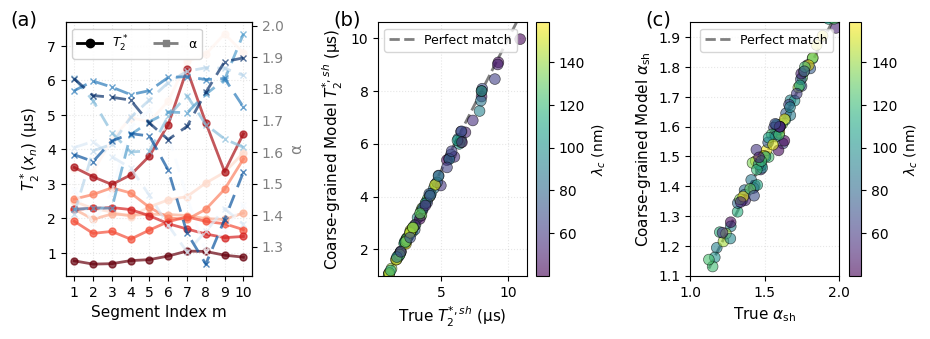

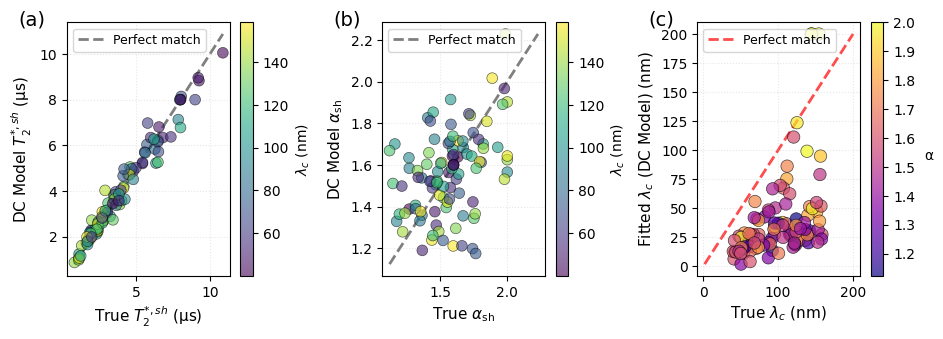


Correlation Length Recovery Statistics:
Mean absolute error: 0.3202 (64.04 nm)
Mean absolute relative error: 64.18%
Root mean square error (RMSE): 0.3574 (71.47 nm)
Correlation coefficient: 0.4570


In [9]:


T2_cont_arr = np.array(results['T2_continuous']) * PERIOD_PHYSICAL
T2_bucket_arr = np.array(results['T2_bucket']) * PERIOD_PHYSICAL
T2_dc_arr = np.array(results['T2_dc']) * PERIOD_PHYSICAL
alpha_cont_arr = np.array(results['alpha_continuous'])
alpha_bucket_arr = np.array(results['alpha_bucket'])
alpha_dc_arr = np.array(results['alpha_dc'])
xc_arr = np.array(results['xc'])
xc_fitted_dc_arr = np.array(results['xc_fitted_dc'])

# Convert xc to nanometers (DISTANCE = 1.0 corresponds to DISTANCE_NM = 200 nm)
xc_arr_nm = xc_arr * DISTANCE_NM
xc_fitted_dc_arr_nm = xc_fitted_dc_arr * DISTANCE_NM


fig1, axes1 = plt.subplots(1, 3, figsize=(9.5, 3.5))
plt.subplots_adjust(wspace=0.0)


ax00 = axes1[0]
if len(results['T2_per_bucket']) > 0:
    bucket_indices = np.arange(N_BUCKETS)
    n_configs = len(results['T2_per_bucket'])
    
    # Get color map for different configurations
    colors = plt.cm.Reds(np.linspace(0, 1, min(n_configs, 8)))  # Use up to 10 colors
    colors_alpha = plt.cm.Blues(np.linspace(0, 1, min(n_configs, 8)))  # Use up to 10 colors

    # Plot T2 (solid lines) for each configuration
    lines_T2 = []
    for i, (T2_buckets, color) in enumerate(zip(results['T2_per_bucket'], colors)):
        line = ax00.plot(bucket_indices, T2_buckets, 'o-', 
                        color=color, linewidth=2, markersize=5, 
                        alpha=0.7, zorder=3, label=rf'$T_2^*$ (config {i+1})' if i < 3 else '')
        lines_T2.extend(line)
    
    # Plot alpha (dashed lines) on twin axis for each configuration
    ax00_twin = ax00.twinx()
    lines_alpha = []
    for i, (alpha_buckets, color) in enumerate(zip(results['alpha_per_bucket'], colors_alpha)):
        line = ax00_twin.plot(bucket_indices, alpha_buckets, 'x--', 
                             color=color, linewidth=2, markersize=4, 
                             dashes=(5, 3), alpha=0.7, zorder=2, 
                             label=f'α (config {i+1})' if i < 3 else '')
        lines_alpha.extend(line)
    
    ax00.set_xlabel("Segment Index m", fontsize=11)
    ax00.set_ylabel(r"$T_2^*(x_n)$ (µs)", fontsize=11, color='black')
    ax00_twin.set_ylabel("α", fontsize=11, color='gray')
    ax00.set_xticks(bucket_indices)
    ax00.set_xticklabels(bucket_indices+1)
    ax00.grid(True, alpha=0.3, linestyle=':', zorder=0)
    ax00.tick_params(axis='y', labelcolor='black')
    ax00_twin.tick_params(axis='y', labelcolor='gray')
    
    # Add simple legend showing T2* and α line styles
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], color='black', linewidth=2, linestyle='-', marker='o', label=r'$T_2^*$', markersize=6),
        Line2D([0], [0], color='gray', linewidth=2, linestyle='--', marker='s', label='α', markersize=5)
    ]
    ax00.legend(handles=legend_elements, loc='upper left', fontsize=9, framealpha=0.9, ncol=2)
else:
    ax00.text(0.5, 0.5, 'No per-bucket data available', 
             ha='center', va='center', transform=ax00.transAxes)



ax01 = axes1[1]
scatter01 = ax01.scatter(T2_cont_arr, T2_bucket_arr, 
                         c=xc_arr_nm, s=60, alpha=0.6, 
                         cmap='viridis', edgecolors='black', linewidth=0.5, zorder=3)
min_T2_01 = min(T2_cont_arr.min(), T2_bucket_arr.min())
max_T2_01 = max(T2_cont_arr.max(), T2_bucket_arr.max())
ax01.plot([min_T2_01, max_T2_01], [min_T2_01, max_T2_01], 'k--', 
         linewidth=2, label='Perfect match', alpha=0.5, zorder=1)
ax01.set_xlabel(r"True $T_{2}^{*,sh}$ (µs)", fontsize=11)
ax01.set_ylabel(r"Coarse-grained Model $T_{2}^{*,sh}$ (µs)", fontsize=11)
ax01.legend(fontsize=9, loc="upper left")
ax01.grid(True, alpha=0.3, linestyle=':')
cbar01 = plt.colorbar(scatter01, ax=ax01)
cbar01.set_label(r'$\lambda_c$ (nm)', fontsize=10)
ax01.set_ylim(1,10.6)


ax11 = axes1[2]
scatter11 = ax11.scatter(alpha_cont_arr, alpha_bucket_arr, 
                         c=xc_arr_nm, s=60, alpha=0.6, 
                         cmap='viridis', edgecolors='black', linewidth=0.5, zorder=3)
min_alpha_11 = min(alpha_cont_arr.min(), alpha_bucket_arr.min())
max_alpha_11 = max(alpha_cont_arr.max(), alpha_bucket_arr.max())
ax11.plot([min_alpha_11, max_alpha_11], [min_alpha_11, max_alpha_11], 'k--', 
         linewidth=2, label='Perfect match', alpha=0.5, zorder=1)
ax11.set_xlabel(r"True $\alpha_\mathrm{sh}$", fontsize=11)
ax11.set_ylabel(r"Coarse-grained Model $\alpha_\mathrm{sh}$", fontsize=11)
ax11.legend(fontsize=9)
ax11.grid(True, alpha=0.3, linestyle=':')
cbar11 = plt.colorbar(scatter11, ax=ax11)
cbar11.set_label(r'$\lambda_c$ (nm)', fontsize=10)
ax11.set_ylim(1.1,1.95)
# Add subplot label
ax11.set_xlim(1,2)
labels = ['(a)', '(b)', '(c)']
for ax, label in zip([ax00, ax01, ax11], labels):
    ax.text(-0.3, 1.05, label,  transform=ax.transAxes, fontsize=14,
          verticalalignment='top', horizontalalignment='left')

plt.tight_layout()
plt.savefig(f'{figures_path}/app_fig11_benchmark_bucket_model.pdf', dpi=300, bbox_inches='tight')
plt.show()


fig2, axes2 = plt.subplots(1, 3, figsize=(9.5, 3.5))
plt.subplots_adjust(wspace=0.01)


ax10 = axes2[2]
alpha_cont_arr = alpha_cont_arr.clip(1,2)
scatter_xc = ax10.scatter(xc_arr_nm, xc_fitted_dc_arr_nm, 
                         c=alpha_cont_arr, s=80, alpha=0.7, 
                         cmap='plasma', edgecolors='black', linewidth=0.5, zorder=3)
min_xc = min(xc_arr_nm.min(), xc_fitted_dc_arr_nm.min())
max_xc = max(xc_arr_nm.max(), xc_fitted_dc_arr_nm.max())
ax10.plot([min_xc, max_xc], [min_xc, max_xc], 'r--', linewidth=2, 
         label='Perfect match', alpha=0.7, zorder=1)
ax10.set_xlabel("True $\lambda_c$ (nm)", fontsize=11)
ax10.set_ylabel("Fitted $\lambda_c$ (DC Model) (nm)", fontsize=11)
ax10.legend(fontsize=9, loc='upper left')
ax10.grid(True, alpha=0.3, linestyle=':')
cbar_xc = plt.colorbar(scatter_xc, ax=ax10)
cbar_xc.set_label('α', fontsize=10, rotation=0, labelpad=10)



ax02 = axes2[0]
scatter02 = ax02.scatter(T2_cont_arr, T2_dc_arr, 
                         c=xc_arr_nm, s=60, alpha=0.6, 
                         cmap='viridis', edgecolors='black', linewidth=0.5, zorder=3)
min_T2_02 = min(T2_cont_arr.min(), T2_dc_arr.min())
max_T2_02 = max(T2_cont_arr.max(), T2_dc_arr.max())
ax02.plot([min_T2_02, max_T2_02], [min_T2_02, max_T2_02], 'k--', 
         linewidth=2, label='Perfect match', alpha=0.5, zorder=1)
ax02.set_xlabel(r"True $T_{2}^{*,sh}$ (µs)", fontsize=11)
ax02.set_ylabel(r"DC Model $T_{2}^{*,sh}$ (µs)", fontsize=11)
ax02.legend(fontsize=9)
ax02.grid(True, alpha=0.3, linestyle=':')
cbar02 = plt.colorbar(scatter02, ax=ax02)   
cbar02.set_label(r'$\lambda_c$ (nm)', fontsize=10)    

# Add subplot label


ax12 = axes2[1]
scatter12 = ax12.scatter(alpha_cont_arr, alpha_dc_arr, 
                         c=xc_arr_nm, s=60, alpha=0.6, 
                         cmap='viridis', edgecolors='black', linewidth=0.5, zorder=3)
min_alpha_12 = min(alpha_cont_arr.min(), alpha_dc_arr.min())
max_alpha_12 = max(alpha_cont_arr.max(), alpha_dc_arr.max())
ax12.plot([min_alpha_12, max_alpha_12], [min_alpha_12, max_alpha_12], 'k--', 
         linewidth=2, label='Perfect match', alpha=0.5, zorder=1)
ax12.set_xlabel(r"True $\alpha_\mathrm{sh}$", fontsize=11)
ax12.set_ylabel(r"DC Model $\alpha_\mathrm{sh}$", fontsize=11)
ax12.legend(fontsize=9)
ax12.grid(True, alpha=0.3, linestyle=':')
cbar12 = plt.colorbar(scatter12, ax=ax12)
cbar12.set_label(r'$\lambda_c$ (nm)', fontsize=10)

labels = ['(a)', '(b)', '(c)']
for ax, label in zip([ax02,ax12,ax10], labels):
    ax.text(-0.3, 1.05, label,  transform=ax.transAxes, fontsize=14,
          verticalalignment='top', horizontalalignment='left')


plt.tight_layout()
plt.savefig(f'{figures_path}/app_fig12_benchmark_dc_model.pdf', dpi=300, bbox_inches='tight')
plt.show()

# Print statistics
print(f"\n{'='*60}")
print(f"Correlation Length Recovery Statistics:")
print(f"{'='*60}")
xc_error = xc_fitted_dc_arr - xc_arr
xc_error_nm = xc_error * DISTANCE_NM  # Convert error to nm
xc_relative_error = xc_error / xc_arr * 100
mean_abs_error = np.mean(np.abs(xc_error))
mean_abs_error_nm = mean_abs_error * DISTANCE_NM
mean_abs_rel_error = np.mean(np.abs(xc_relative_error))
rmse = np.sqrt(np.mean(xc_error**2))
rmse_nm = rmse * DISTANCE_NM
print(f"Mean absolute error: {mean_abs_error:.4f} ({mean_abs_error_nm:.2f} nm)")
print(f"Mean absolute relative error: {mean_abs_rel_error:.2f}%")
print(f"Root mean square error (RMSE): {rmse:.4f} ({rmse_nm:.2f} nm)")
print(f"Correlation coefficient: {np.corrcoef(xc_arr, xc_fitted_dc_arr)[0,1]:.4f}")

